# SYSC4906 Assignment 3

**Group Name:** 

**Student names:** Luke Newton, Eric Bedard

**Student numbers:** 


# Discussion of Solution
Your notebook must begin with **this** text cell containing a description of your solution. In this discussion, include links to any resources that you used in developing your solution. Use proper MarkDown syntax to format your discussion.**This description should be approximately 500 words in length and cover the following:**

1. Which machine learning approach did you use?

2. How did you split your data between training and testing? 
_(e.g. hold-out test, cross-validation, repeated bootstrap samples, etc)_

3. How did you train your classifier?
If you used transfer learning, describe how you did so.

4. How did you estimate your future performance _(worst recall, best precision, overall accuracy)_?

   **Here are our final predictions:**
   1. Building with worst recall:
   2. Building with best precision
   3. Overall accuracy)

5. Discuss the performance of your model. Which buildings did it do the best/worst on and why? What are the strengths and limitations of your method. 

6. What would you have done differently if you had more time?


# Code to Train Your Method
_We will look at this, but will not run it when measuring your accuracy. Please structure your training code into logical steps, so that we can easily understand it_
## Step 1: Load the image dataset

precondition: image zip must first be uploaded to google colab. As the download link is on cuLearn, we cannot directly download the file here

In [1]:
from glob import glob

# List of building codes to use throughout notebook.
buildingCodes = ('AA', 'CB', 'CT', 'DT', 'FH', 'HP', 'HS', 'LB', 'MC', 'ME', 'ML', 'PA', 'RB', 'RO', 'SA', 'TB')

!unzip All_Images_500x500.zip

#get list of file names for each building and place into a dictionary
building_images = {}
for name in buildingCodes:
  building_images[name] = glob('All_Images_500x500/' + name + '/*.jpg')

Archive:  All_Images_500x500.zip
   creating: All_Images_500x500/
   creating: All_Images_500x500/AA/
  inflating: All_Images_500x500/AA/030_1.jpg  
  inflating: All_Images_500x500/AA/030_2.jpg  
  inflating: All_Images_500x500/AA/030_3.jpg  
  inflating: All_Images_500x500/AA/030_4.jpg  
  inflating: All_Images_500x500/AA/030_5.jpg  
  inflating: All_Images_500x500/AA/081_1.jpg  
  inflating: All_Images_500x500/AA/081_2.jpg  
  inflating: All_Images_500x500/AA/081_3.jpg  
  inflating: All_Images_500x500/AA/081_4.jpg  
  inflating: All_Images_500x500/AA/081_5.jpg  
  inflating: All_Images_500x500/AA/120-1.jpg  
  inflating: All_Images_500x500/AA/120-2.jpg  
  inflating: All_Images_500x500/AA/120-3.jpg  
  inflating: All_Images_500x500/AA/120-4.jpg  
  inflating: All_Images_500x500/AA/120-5.jpg  
  inflating: All_Images_500x500/AA/120-6.jpg  
  inflating: All_Images_500x500/AA/128-1.jpg  
  inflating: All_Images_500x500/AA/128-2.jpg  
  inflating: All_Images_500x500/AA/128-3.jpg  
  inf

##Step 2: check that data was loaded correctly

optional step for data visualization

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

for building in building_images:
  #display number of images in folder
  print(building, ":", len(building_images.get(building)), "images")
  print('sample:')
  #display first image in a folder
  plt.figure(figsize=(8,8))
  plt.imshow(Image.open(building_images.get(building)[0]))
  plt.show()

##Step 3: split images into train and test

the test_image folder will be used after model has been learned to observe performance on images that the model has not seen before, in order to get an idea of how the model will perform on the prof/TAs test images

In [0]:
import os, math
from random import randint
from PIL import Image

#the portion of images to hold back for testing later
TEST_RATIO = 0.10

#build directories for test images
if not os.path.exists('test_image'):
    os.makedirs('test_image')
for building in buildingCodes:
  if not os.path.exists('test_image/' + building):
    os.makedirs('test_image/' + building)
  
  #move images from unzipped folder o the holdout set
  building_list = building_images.get(building)
  num_tests = math.floor(len(building_list) * TEST_RATIO)
  for i in range(num_tests):
    image_num = randint(0, len(building_list)-1)
    image = building_list[image_num]
    Image.open(image).save('test_image/' + building + '/' + str(i) + '.jpg')
    building_list.remove(image)
    os.unlink(image)

##Step 4: define preprocessing function for images

before images are input into the network, they should first be normalized

In [3]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

def normalize(img):
  x = img_to_array(img).astype('float32')
  return x / 255.0

Using TensorFlow backend.


##Step 5: build train data

despite having a holdout set, we still split the data into train and validation here so we can comapre the models performance on training and new examples at each training epoch

In [4]:
BATCH_SIZE = 25
WIDTH = 500
HEIGHT = 500

train_datagen = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3, \
                                   horizontal_flip=True, vertical_flip=True, fill_mode='nearest', \
                                   validation_split=0.2, preprocessing_function=normalize)

train_generator = train_datagen.flow_from_directory('/content/All_Images_500x500', target_size=(WIDTH, HEIGHT),\
                                                    batch_size=BATCH_SIZE, class_mode='categorical', subset='training')

validation_generator = train_datagen.flow_from_directory('/content/All_Images_500x500', target_size=(WIDTH, HEIGHT),\
                                                    batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')

Found 2426 images belonging to 16 classes.
Found 598 images belonging to 16 classes.


##Step 6: build convolutional neural network

In [5]:
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D

WIDTH = 500
HEIGHT = 500
CHANNELS = 3
CLASSES = 16

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(HEIGHT,WIDTH,CHANNELS)))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (5, 5), activation='relu', strides=(2,2)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu', strides=(2,2)))
model.add(Conv2D(256, (5, 5), activation='relu', strides=(2,2), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(CLASSES))
model.add(Activation('softmax'))

model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 498, 498, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 496, 496, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 494, 494, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 494, 494, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 247, 247, 64)      0        

##Step 7: train CNN

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/300





50/50 [==============================] - 67s 1s/step - loss: 2.7760 - acc: 0.0632 - val_loss: 2.7679 - val_acc: 0.1200
Epoch 2/300
50/50 [==============================] - 63s 1s/step - loss: 2.7742 - acc: 0.0448 - val_loss: 2.7706 - val_acc: 0.0800
Epoch 3/300
50/50 [==============================] - 62s 1s/step - loss: 2.7738 - acc: 0.0584 - val_loss: 2.7731 - val_acc: 0.0000e+00
Epoch 4/300
50/50 [==============================] - 63s 1s/step - loss: 2.7736 - acc: 0.0624 - val_loss: 2.7721 - val_acc: 0.0400
Epoch 5/300
50/50 [==============================] - 61s 1s/step - loss: 2.7729 - acc: 0.0616 - val_loss: 2.7745 - val_acc: 0.0400
Epoch 6/300
50/50 [==============================] - 64s 1s/step - loss: 2.7736 - acc: 0.0584 - val_loss: 2.7691 - val_acc: 0.1200
Epoch 7/300
50/50 [==============================] - 63s 1s/step - loss: 2.7733 - acc: 0.0424 - val_loss: 2.

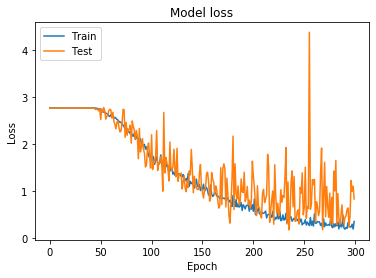

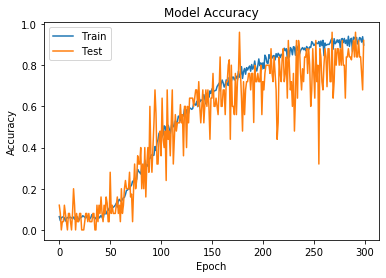

In [6]:
import matplotlib.pyplot as plt

EPOCHS = 300
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 1

history = model.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,\
                              epochs=EPOCHS, validation_data=validation_generator, \
                              validation_steps=VALIDATION_STEPS)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Step 8: test model with holdout set

the accuracy displayed at the end will give us a ballpark estimate of how the model performs on new images

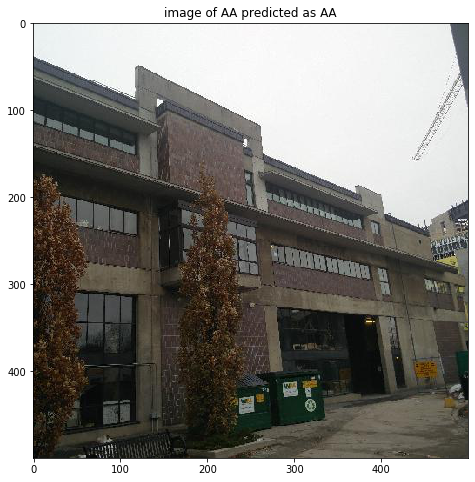

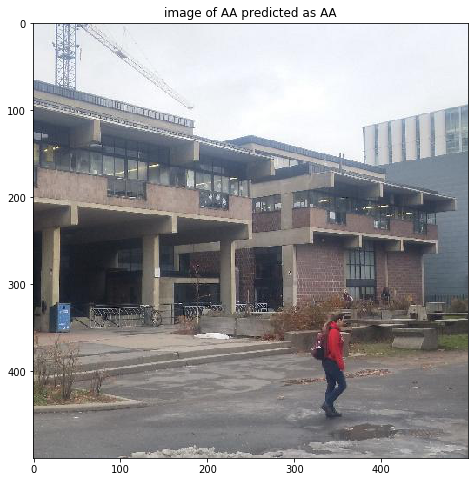

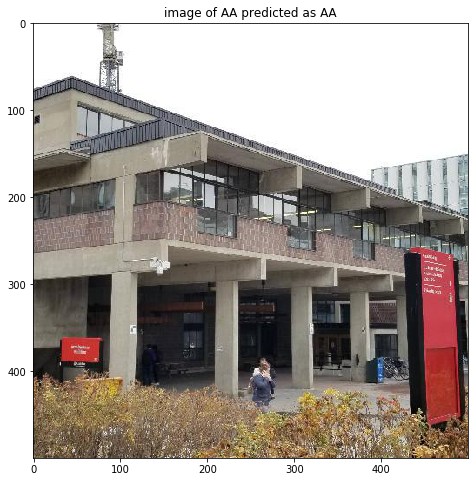

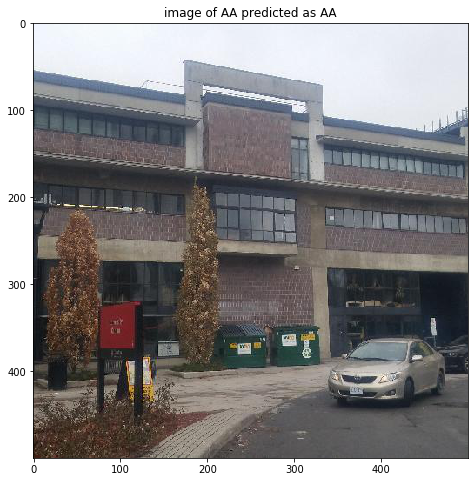

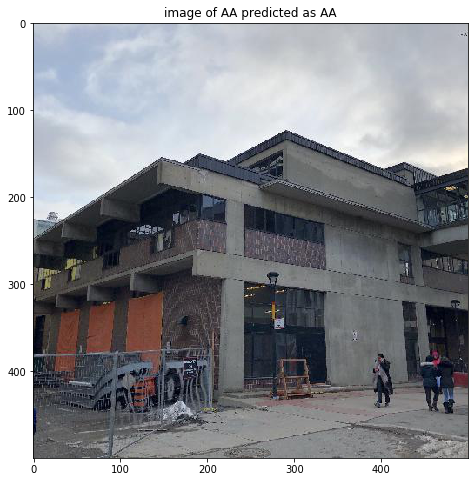

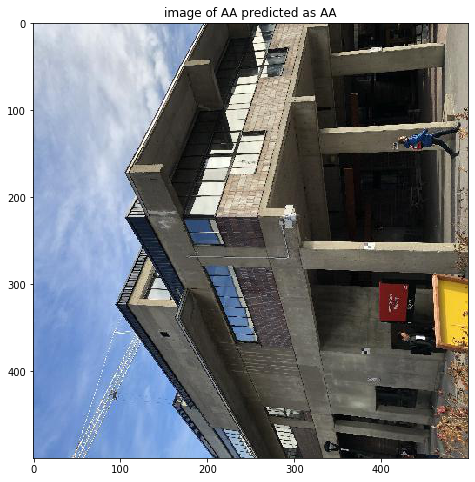

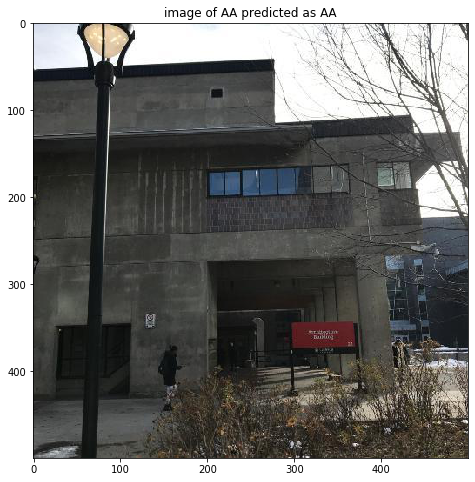

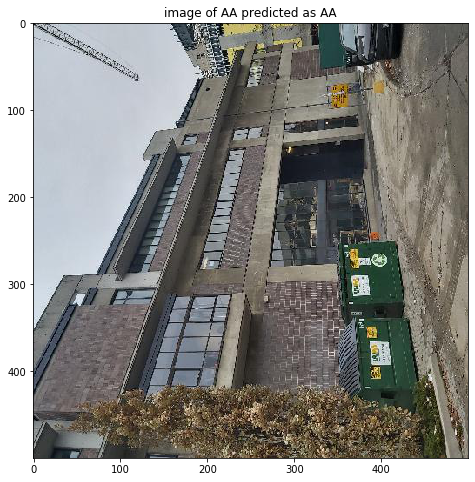

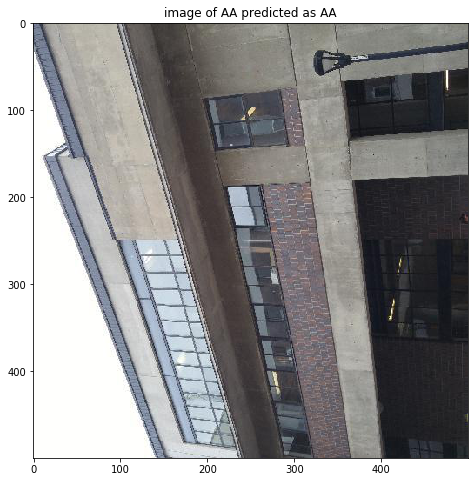

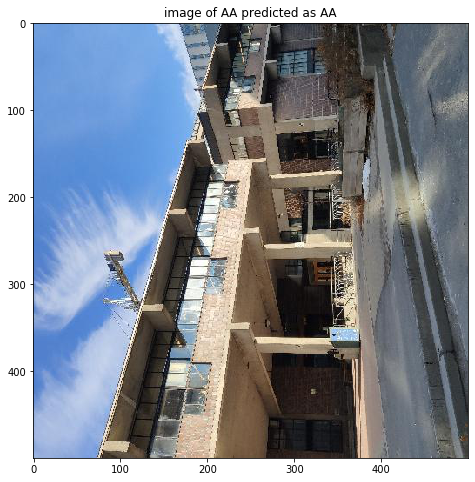

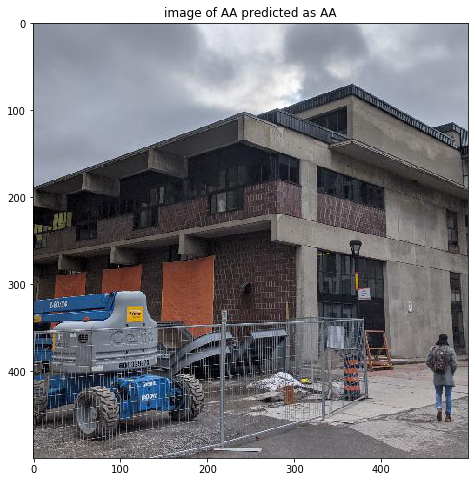

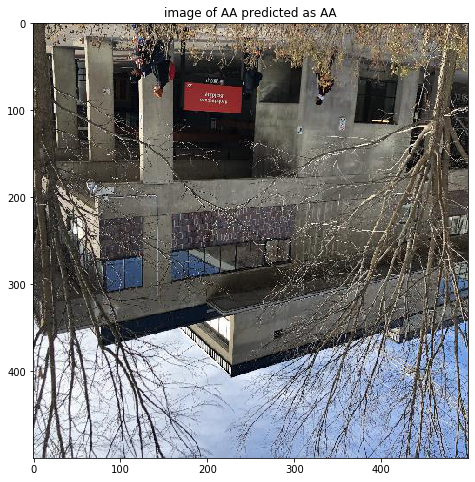

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix

true_labels = list()
predicted_labels = list()
n = 0
correct = 0

#make prediction for each test image
for name in buildingCodes:
  for file in glob('test_image/'+name+'/*.jpg'):
    img = Image.open(file)
    x = normalize(img)
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    label = buildingCodes[np.where(y[0] == max(y[0]))[0][0]]
    plt.title('image of ' + name + ' predicted as ' + label)
    plt.show()
    true_labels.append(name)
    predicted_labels.append(label)
    n += 1
    if name==label:
      correct += 1

#print results
print('number of predictions:', n)
print('number of correct predictions:', correct)
print('accuracy:', correct/n)

#format confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=buildingCodes)
print('                               actual class')
print('                  ', end='')
for name in buildingCodes:
  print(name + ' ', end='')
print()
for i in range(len(buildingCodes)):
  if i == 8:
    print('predicted class', end=' ')
  else:
    print('               ', end=' ')
  print(buildingCodes[i] + ' ', end='')
  for value in cm[i]:
    if value < 10:
      print('0', end='')
    print(str(value) + ' ', end='')
  print()

##Step 9: Save the model to file

In [0]:
import pickle
import os

pickle.dump(model, open(os.path.join('model.pkl'), 'wb'), protocol=4)

#Required functions to test your method
_These are the five required methods that you must implement._

## prepareModel()
This function should prepare your model for multiple invocations of classifyImage(fname). For example, this function could be used to load a pre-trained model from a URL, where that model is then used by  classifyImage(fname). You should use global variables for any variables initialized by this function.

Runtime of this method is **limited to 5 minutes**, so please don’t retrain your network here. All training should be captured in a pre-trained model to be loaded by this method.


In [4]:
import pickle
import os

file = open('model.pkl', 'rb')
model = pickle.load(file)
file.close()

# List of building codes to use throughout notebook.
buildingCodes = ('AA', 'CB', 'CT', 'DT', 'FH', 'HP', 'HS', 'LB', 'MC', 'ME', 'ML', 'PA', 'RB', 'RO', 'SA', 'TB')

def prepareModel():
  global model # Sample global variable that you may populate here.

  file = open('model.pkl', 'rb')
  model = pickle.load(file)
  file.close()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




## label = classifyImage(fname)
Accepts a filename (e.g. ‘test/ME/testImage1.jpg’) of a square JPG image with size at least 500x500 pixels.
Returns a 2-character label corresponding to the predicted building (see table of labels above)

Any variables initialized by prepareModel() should be declared as global within this function if you want to access them (e.g. a pre-trained model)


In [0]:
def classifyImage(fname):
  global model # Sample global variable that you may populate in prepareModel and use here.

  print("Predicting class of '{0:s}' using model '{1:s}'".format(fname,model))
  return buildingCodes[0] #Default behaviour to override


## label = worstRecall()
Returns the label of a building that you expect will have to lowest recall, when tested on new images

In [0]:
def worstRecall():
  return buildingCodes[0] #Default behaviour to override


## label = bestPrecision()
Returns the label of a building that you expect will have to highest precision, when tested on new images

In [0]:
def bestPrecision():
  return buildingCodes[0] #Default behaviour to override


##acc_score = estimatedAccuracy()
Returns the accuracy (between [0.0,1.0]) that you expect to achieve across all test images, assuming that each building is equally represented


In [0]:
# Function to return estimated accuracy that will be obtained across all test images
def estimatedAccuracy():
  return 1.0 #Default behaviour to override

# Test required functions
_We will replace the text below with our actual test code..._

Predicting class of 'SampleImages/AA_1.jpg' using model 'No model loaded.'


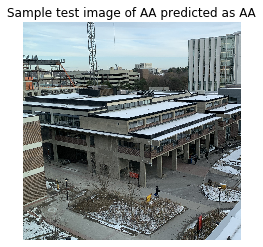

Correct!
Predicting class of 'SampleImages/CB_1.jpg' using model 'No model loaded.'


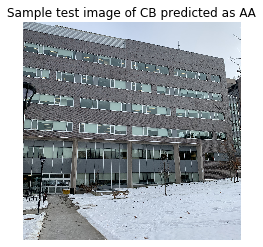

Incorrect...
Predicting class of 'SampleImages/DT_1.jpg' using model 'No model loaded.'


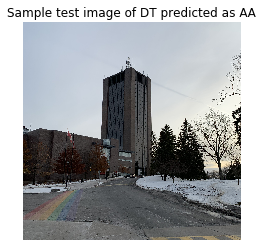

Incorrect...
Predicting class of 'SampleImages/HS_1.jpg' using model 'No model loaded.'


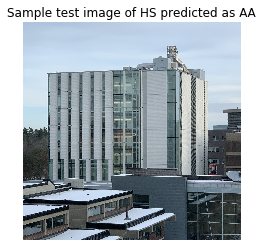

Incorrect...
Expected that worst recall would be on AA
Expected that best precision would be on AA
Expected total accuracy would be 1.000
Actual total accuracy is 0.250


In [0]:
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
from glob import glob


# First prepare the model:
prepareModel() # Limited to 5 minutes...

# Load (secret) test data into local Colab environment
!wget https://github.com/jrgreen7/SYSC4906/blob/master/Assignments/Assignment3/Images/SampleImages.zip?raw=true
!unzip SampleImages.zip?raw=true #Should create 4 images
test_images = sorted(glob('SampleImages/*.jpg'))
actual_labels = (buildingCodes[0],buildingCodes[1],buildingCodes[3],buildingCodes[6])

# Classify sample test images:
TP = 0
for imgFname,actual_label in (zip(test_images,actual_labels)):
  pred_label = classifyImage(imgFname) # Predict the label of this image file

  # Plot the image with actual and predicted labels
  # Note that we may have to rotate the image, depending on the 
  # orientation of the camera. Use EXIF tags for this:
  im = Image.open(imgFname)
  for orientation in ExifTags.TAGS.keys() : 
    if ExifTags.TAGS[orientation]=='Orientation' : break 
  exif=dict(im._getexif().items())

  if exif[orientation] == 3 : 
    im=im.rotate(180, expand=True)
  elif exif[orientation] == 6 : 
    im=im.rotate(270, expand=True)
  elif exif[orientation] == 8 : 
    im=im.rotate(90, expand=True)

  im = im.convert('RGB') # May not be necessary?

  plt.title("Sample test image of {0:s} predicted as {1:s}".format(actual_label, pred_label))
  plt.imshow(np.asarray(im))
  plt.axis('off')
  plt.show()

  if (pred_label==actual_label):
    print('Correct!')
    TP += 1
  else:
    print("Incorrect...")

# Print the predicted performance:
print("Expected that worst recall would be on {0:s}".format(worstRecall()))
print("Expected that best precision would be on {0:s}".format(bestPrecision()))
print("Expected total accuracy would be {0:.3f}".format(estimatedAccuracy()))
print("Actual total accuracy is {0:.3f}".format((TP)/(len(test_images))))
